# Importing libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [3]:
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb

In [4]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

# Importing Data

In [6]:
#start_date=datetime.datetime(2020,1,1)
start_date=datetime.datetime(2020,1,1)
today=datetime.datetime.today()

In [7]:
days=(today-start_date).days
days

1881

In [8]:
remaining=days%500
numbers_of_table=days//500

In [9]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:30].to_list()

In [10]:
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(data)
    
temp_end=(today-datetime.timedelta(days))
data=Binance.get_price(tickers,temp_end)
omusdt=Binance.get_price(['OMUSDT'],temp_end)
prices=prices.combine_first(data)
prices=prices.sort_index()
prices = prices[~prices.index.duplicated(keep='first')]
prices['OMUSDT']=omusdt

In [11]:
returns=np.log(1+prices.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na].sort_index()

C:\Users\Admin\AppData\Local\Temp\ipykernel_2400\2972560492.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns=np.log(1+prices.pct_change())


In [12]:
dataframe=prices[with_no_na].sort_index()
dataframe.index=pd.to_datetime(dataframe.index)

In [13]:
returns_to_use.index=pd.to_datetime(returns_to_use.index)
returns_to_use = returns_to_use[~returns_to_use.index.duplicated(keep='first')]

# Strategy Backtesting

In [15]:
month=list(sorted(set(returns_to_use.index + pd.offsets.BMonthEnd(0))))
#month_end=pd.to_datetime(mrat_wo_na.index)
month = pd.to_datetime(month)

idx1 = pd.Index(returns_to_use.iloc[:-1].index)
idx2 = pd.Index(month)
closest_dates = idx1[idx1.get_indexer(idx2, method='nearest')]

dates_end=list(closest_dates)
dates_end.insert(0,returns_to_use.index[1])
dates_end.append(returns_to_use.index[-1])
dates_end=sorted(list(set(dates_end)))
dates_end.pop(0)
dates_end=sorted(list(set(dates_end)))

In [16]:
returns_to_use

,ADAUSDT,BCHUSDT,BNBUSDT,BTCUSDT,DOGEUSDT,ETHUSDT,HBARUSDT,LINKUSDT,LTCUSDT,TRXUSDT,USDCUSDT,XLMUSDT,XRPUSDT
2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01,0.018997,-0.000391,0.000168,0.000781,0.005448,0.012388,0.010685,0.024481,0.007718,-0.006033,-0.000100,0.007535,0.000518
2020-01-02,-0.023879,-0.044765,-0.052981,-0.033200,-0.014629,-0.027758,-0.033402,-0.042005,-0.054054,-0.029166,-0.000798,-0.037800,-0.029170
2020-01-03,0.044279,0.129103,0.047792,0.053015,0.014184,0.054766,0.033402,0.038077,0.068604,0.045670,-0.001597,0.045936,0.030878
2020-01-04,0.004963,0.009130,0.011786,0.001245,0.016808,-0.001117,0.070859,0.011135,0.012940,0.000000,-0.000300,-0.000219,-0.001708
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-20,0.037788,0.009558,0.004551,0.017037,-0.000236,0.008266,0.028552,0.016548,-0.030563,0.016367,-0.000300,0.008156,-0.018469
2025-02-21,-0.053024,-0.037835,-0.013637,-0.021833,-0.061022,-0.027789,-0.035061,-0.047615,-0.021011,-0.035106,0.000700,-0.055470,-0.043963
2025-02-22,0.014719,0.022374,0.032069,0.003829,0.028384,0.036943,0.009470,0.018756,-0.017323,0.005868,-0.000500,0.025134,0.000738
2025-02-23,-0.004796,0.021274,-0.015298,-0.003039,-0.015161,0.020230,-0.024320,-0.007914,0.030892,0.027614,0.000100,-0.003895,0.000893


In [17]:
results={}
btc_limit=np.where(returns_to_use.columns=='BTCUSDT')[0][0]
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0]
#om_limit=np.where(returns_to_use.columns=='OMUSDT')[0][0]

In [18]:
for i in range(len(dates_end)-1):
    
    try:
        dataset=returns_to_use.loc[dates_end[i]:dates_end[i+1]]        
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        
        optimal=risk.optimize(objective='minimum_variance',constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00}])#,
                                                                        #{'type': 'eq', 'fun': lambda weights: weights[om_limit]-0.5}])
        
        
        results[date]=np.round(optimal,6)

    except Exception as e:
        
        pass

rolling_optimization=pd.DataFrame(results,index=dataframe.columns).T

In [19]:
tracking={}
portfolio={}
investment_amount=1000
initial_amount=investment_amount
perf=dataframe.pct_change()
transaction_fee=0.005

weight_dict={col: 1/returns_to_use.shape[1] for col in returns_to_use.columns}


for i in range(len(dates_end)-1):
    
    print(dates_end[i],investment_amount,investment_amount/initial_amount)

    
    temp=dataframe.loc[dates_end[i]:dates_end[i+1]].copy()
    initial_price=temp.iloc[0].to_dict()

    if dates_end[i]>dates_end[0]:

        top50=rolling_optimization.loc[dates_end[i]]
        top50_dict=rolling_optimization.loc[dates_end[i]].to_dict()
        weight_dict={}

        for key in temp.columns:

            if key in top50_dict: 
                weight_dict[key]=top50_dict[key]
            else:
                weight_dict[key]=0
      
                
    weight_vec=np.array(list(weight_dict.values()))
    
    inital_investment_per_stock={}
    shares={}

    for col in temp.columns:
        
        weighted_perf=weight_vec*perf.loc[dates_end[i]]
        
        inital_investment_per_stock[col]=weight_dict[col]*investment_amount*(1+weighted_perf.sum())
        shares[col]=inital_investment_per_stock[col]*(1-transaction_fee)/initial_price[col]

    tracking[dates_end[i]]=(weight_dict,shares,investment_amount,initial_price)

    temp=temp*shares    
    portfolio[dates_end[i]]=temp
    investment_amount=temp.iloc[-1].sum()
    

temp=dataframe.loc[dates_end[-2]:]*shares
portfolio[dates_end[-1]]=temp

2020-01-01 00:00:00 1000 1.0
2020-01-31 00:00:00 1392.191885753699 1.3921918857536988
2020-02-28 00:00:00 1923.461840356624 1.923461840356624
2020-03-31 00:00:00 1390.4900298526545 1.3904900298526546
2020-04-30 00:00:00 1915.6782679840535 1.9156782679840534
2020-05-29 00:00:00 2028.4687680535626 2.0284687680535627
2020-06-30 00:00:00 1943.3624313761002 1.9433624313761002
2020-07-31 00:00:00 2766.936859083299 2.766936859083299
2020-08-31 00:00:00 2890.9185638263666 2.8909185638263666
2020-09-30 00:00:00 2665.2305193389557 2.6652305193389556
2020-10-30 00:00:00 2997.678005951731 2.9976780059517307
2020-11-30 00:00:00 4222.086811436589 4.222086811436589
2020-12-31 00:00:00 5413.04960287973 5.41304960287973
2021-01-29 00:00:00 8205.640214183273 8.205640214183273
2021-02-26 00:00:00 33238.03969224206 33.23803969224206
2021-03-31 00:00:00 41431.527453594754 41.431527453594754
2021-04-30 00:00:00 94691.3082445248 94.6913082445248
2021-05-31 00:00:00 76919.6271642741 76.9196271642741
2021-06-3

C:\Users\Admin\AppData\Local\Temp\ipykernel_2400\3371734425.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  perf=dataframe.pct_change()


In [20]:
historical_portfolio=pd.DataFrame()
performance=pd.DataFrame()
for key in portfolio.keys():
    historical_portfolio=historical_portfolio.combine_first(portfolio[key])

In [21]:
historical_portfolio.sum(axis=1)

2020-01-01      1001.345456
2020-01-02       969.339477
2020-01-03      1015.613849
2020-01-04      1026.357950
2020-01-05      1032.823877
                  ...      
2025-02-20    286946.841491
2025-02-21    281112.530179
2025-02-22    287112.815753
2025-02-23    284184.178585
2025-02-24    273672.614869
Length: 1882, dtype: float64

<Axes: >

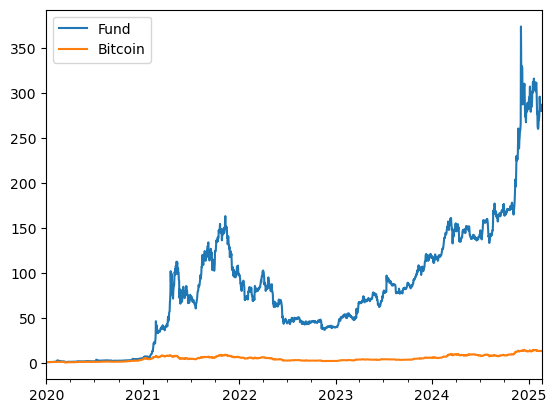

In [22]:
performance['Fund']=historical_portfolio.sum(axis=1)
performance['Bitcoin']=dataframe['BTCUSDT']
#performance['Mantra']=dataframe['OMUSDT']

performance_pct=performance.copy()
performance_pct=performance_pct.pct_change()

(1+performance_pct.iloc[:-2]).cumprod().plot()

In [23]:
years=sorted(list(set(performance.index.year)))

month_year=performance.index.strftime('%Y-%m')
month_year=sorted(list(set(month_year)))

<Axes: >

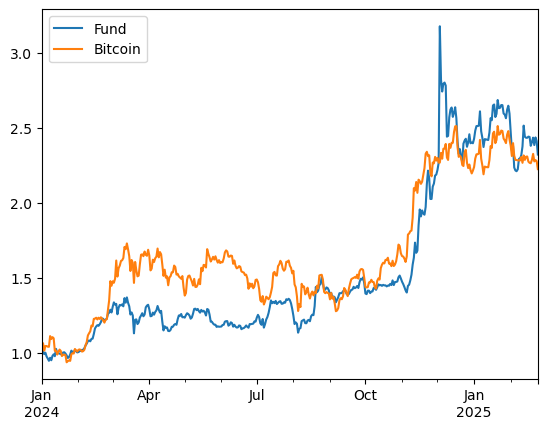

In [73]:
(1+performance_pct.loc['2024':]).cumprod().plot()

In [25]:
year_returns={}
for year in years:

    perf_year=performance.loc[str(year)].iloc[-1]/performance.loc[str(year)].iloc[0]-1
    year_returns[year]=perf_year

year_returns[years[-1]]=performance.loc[str(years[-1])].iloc[-2]/performance.loc[str(years[-1])].iloc[0]-1

In [26]:
year_returns_dataframe=pd.DataFrame(year_returns)
year_returns_dataframe

,2020,2021,2022,2023,2024,2025
Fund,4.405776,16.972108,-0.592852,1.949954,1.375387,-0.006580
Bitcoin,3.016697,0.575665,-0.653364,1.544636,1.118084,0.017615


In [27]:
month_returns={}
for month in month_year:

    perf_year=performance.loc[str(month)].iloc[-1]/performance.loc[str(month)].iloc[0]-1
    month_returns[month]=perf_year

month_returns[month]=performance.loc[str(month_year[-1])].iloc[-2]/performance.loc[str(month_year[-1])].iloc[0]-1

In [28]:
month_returns_dataframe=pd.DataFrame(month_returns)
month_returns_dataframe

,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,...,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02
Fund,0.390321,0.301385,-0.248649,0.333390,0.062600,-0.102272,0.398100,-0.013991,-0.095351,0.137320,...,-0.048278,0.027922,0.047577,0.135684,0.058098,0.071990,0.484732,0.080336,0.069191,-0.026363
Bitcoin,0.298859,-0.091746,-0.248649,0.297622,0.070388,-0.104131,0.227844,-0.012851,-0.096073,0.298694,...,0.157201,-0.073706,0.027472,-0.097623,0.105158,0.156009,0.387245,-0.037137,0.082859,-0.043500


In [29]:
metrics={}
metrics['Tracking Error']=(performance_pct['Fund']-performance_pct['Bitcoin']).std()*np.sqrt(252)
metrics['Fund Vol']=performance_pct['Fund'].std()*np.sqrt(252)
metrics['Bench Vol']=performance_pct['Bitcoin'].std()*np.sqrt(252)
metrics['Fund Return']=performance['Fund'].iloc[-2]/performance['Fund'].iloc[0]
metrics['Bench Return']=performance['Bitcoin'].iloc[-2]/performance['Bitcoin'].iloc[0]
metrics['Sharpe Ratio']=(1+metrics['Fund Return'])**(1/len(set(returns_to_use.index.year)))/metrics['Fund Vol']

In [30]:
indicators=pd.DataFrame(metrics.values(),index=metrics.keys(),columns=['Indicators'])
indicators

,Indicators
Tracking Error,0.549528
Fund Vol,0.724391
Bench Vol,0.535308
Fund Return,283.802335
Bench Return,13.367589
Sharpe Ratio,3.095108


In [31]:
tracking[dates_end[-2]][0]

{'ADAUSDT': 0.121981,
 'BCHUSDT': 0.0,
 'BNBUSDT': 0.0,
 'BTCUSDT': 0.878019,
 'DOGEUSDT': 0.0,
 'ETHUSDT': 0.0,
 'HBARUSDT': 0.0,
 'LINKUSDT': 0.0,
 'LTCUSDT': 0.0,
 'TRXUSDT': 0.0,
 'USDCUSDT': 0.0,
 'XLMUSDT': 0.0,
 'XRPUSDT': 0.0}